In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/sur/src/" /content
!cp -r "/content/drive/MyDrive/Colab Notebooks/sur/data/" /content

In [53]:
import sys
sys.path.append('.')

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import matplotlib.pyplot as plt
import os

import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset
print(torch.__version__)

from src.dataset import ImageDataset
from src.config import Config

cfg = Config()

2.2.1+cu121


In [55]:
# Training dataset
train_dataset = ImageDataset(root_dir=cfg.DATA_DIR, train=True, transform=cfg.TRANSFORM_TRAIN)
# Testing/validation dataset
test_dataset = ImageDataset(root_dir=cfg.DATA_DIR, train=False, transform=cfg.TRANSFORM_TEST)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 151
Number of testing samples: 70


In [56]:
from torch.utils.data import DataLoader

# no num_workers or some weird stuff
train_dataloader_display = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True)
test_dataloader_display = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

Feature batch shape: torch.Size([1, 3, 80, 80])
Labels batch shape: torch.Size([1])
Label: 0


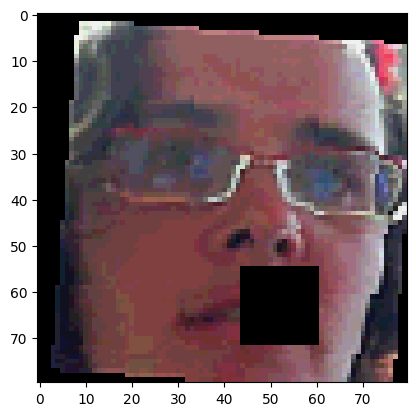

In [60]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader_display))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
print(f"Label: {label}")
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [61]:
# no num_workers or some weird stuff
train_dataloader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, pin_memory=True)

In [115]:
from torch.optim import SGD, Adam
from src.models.resnet9 import ResNet9
from src.models.convmixer import ConvMixer
from src.models.preact_resnet import PreActResNet18, PreActResNet34

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
else:
    print('Using CPU')

model_preact_resnet34 = PreActResNet34().to(device)
# model_preact_resnet18 = PreActResNet18().to(device)
# model_convmixer = ConvMixer(768, 32).to(device)
# model_resnet9 = ResNet9(3, cfg.NUM_CLASSES).to(device)
optimizer_sgd = SGD(model_preact_resnet34.parameters(), lr=0.000025, momentum=cfg.MOMENTUM, weight_decay=cfg.WEIGHT_DECAY, nesterov=cfg.NESTEROV)
optimizer_adam = Adam(model_preact_resnet34.parameters(), lr=0.000005, weight_decay=cfg.WEIGHT_DECAY)

Tesla T4


In [116]:
print(model_preact_resnet34.count_parameters())
# print(model_preact_resnet18.count_parameters())
#print(model_convmixer.count_parameters())
#print(model_resnet9.count_parameters())

21275202


In [117]:
from src.trainmodel import train

print(f"Training on {len(train_dataset)} samples and validating on {len(test_dataset)} samples")
history, best_model_w, best_epoch = train(model_preact_resnet34, train_dataloader, test_dataloader, 569, optimizer_adam,
       device, cfg, 0.05, verbose=True)

Training on 151 samples and validating on 70 samples
New best model found! Loss: 1.0442
[Epoch: 01/569] - 1.40s | LR: 0.000005 | Train Loss: 0.4943 | Train Acc: 79.20 | Test Loss: 0.5499 | Test Acc: 85.71
New best model found! Loss: 0.8861
[Epoch: 02/569] - 1.38s | LR: 0.000005 | Train Loss: 0.4402 | Train Acc: 85.89 | Test Loss: 0.4459 | Test Acc: 85.71
New best model found! Loss: 0.7981
[Epoch: 03/569] - 1.40s | LR: 0.000005 | Train Loss: 0.4010 | Train Acc: 86.70 | Test Loss: 0.3971 | Test Acc: 85.71
New best model found! Loss: 0.7843
[Epoch: 04/569] - 1.36s | LR: 0.000005 | Train Loss: 0.4055 | Train Acc: 85.89 | Test Loss: 0.3788 | Test Acc: 85.71
New best model found! Loss: 0.7533
[Epoch: 05/569] - 1.35s | LR: 0.000005 | Train Loss: 0.3756 | Train Acc: 86.70 | Test Loss: 0.3777 | Test Acc: 85.71
New best model found! Loss: 0.7436
[Epoch: 06/569] - 1.36s | LR: 0.000005 | Train Loss: 0.3732 | Train Acc: 86.70 | Test Loss: 0.3704 | Test Acc: 85.71
[Epoch: 07/569] - 1.36s | LR: 0.000

In [120]:
# continue training from best model using lower lr
model_preact_resnet34.load_state_dict(best_model_w)
optimizer_sgd = SGD(model_preact_resnet34.parameters(), lr=0.0000005, momentum=0.975, weight_decay=cfg.WEIGHT_DECAY, nesterov=cfg.NESTEROV)
optimizer_adam = Adam(model_preact_resnet34.parameters(), lr=0.0000001, weight_decay=cfg.WEIGHT_DECAY)
history, best_model_w, best_epoch = train(model_preact_resnet34, train_dataloader, test_dataloader, 70, optimizer_adam,
       device, cfg, 0.005, verbose=True)

New best model found! Loss: 0.0118
[Epoch: 01/70] - 1.44s | LR: 0.000000 | Train Loss: 0.0117 | Train Acc: 99.37 | Test Loss: 0.0001 | Test Acc: 100.00
[Epoch: 02/70] - 1.41s | LR: 0.000000 | Train Loss: 0.0152 | Train Acc: 99.37 | Test Loss: 0.0001 | Test Acc: 100.00
New best model found! Loss: 0.0096
[Epoch: 03/70] - 1.37s | LR: 0.000000 | Train Loss: 0.0096 | Train Acc: 100.00 | Test Loss: 0.0001 | Test Acc: 100.00
[Epoch: 04/70] - 1.41s | LR: 0.000000 | Train Loss: 0.0207 | Train Acc: 99.37 | Test Loss: 0.0001 | Test Acc: 100.00
New best model found! Loss: 0.0090
[Epoch: 05/70] - 1.41s | LR: 0.000000 | Train Loss: 0.0089 | Train Acc: 100.00 | Test Loss: 0.0001 | Test Acc: 100.00
New best model found! Loss: 0.0059
[Epoch: 06/70] - 1.38s | LR: 0.000000 | Train Loss: 0.0059 | Train Acc: 100.00 | Test Loss: 0.0001 | Test Acc: 100.00
[Epoch: 07/70] - 1.39s | LR: 0.000000 | Train Loss: 0.0125 | Train Acc: 99.37 | Test Loss: 0.0001 | Test Acc: 100.00
[Epoch: 08/70] - 1.43s | LR: 0.000000 

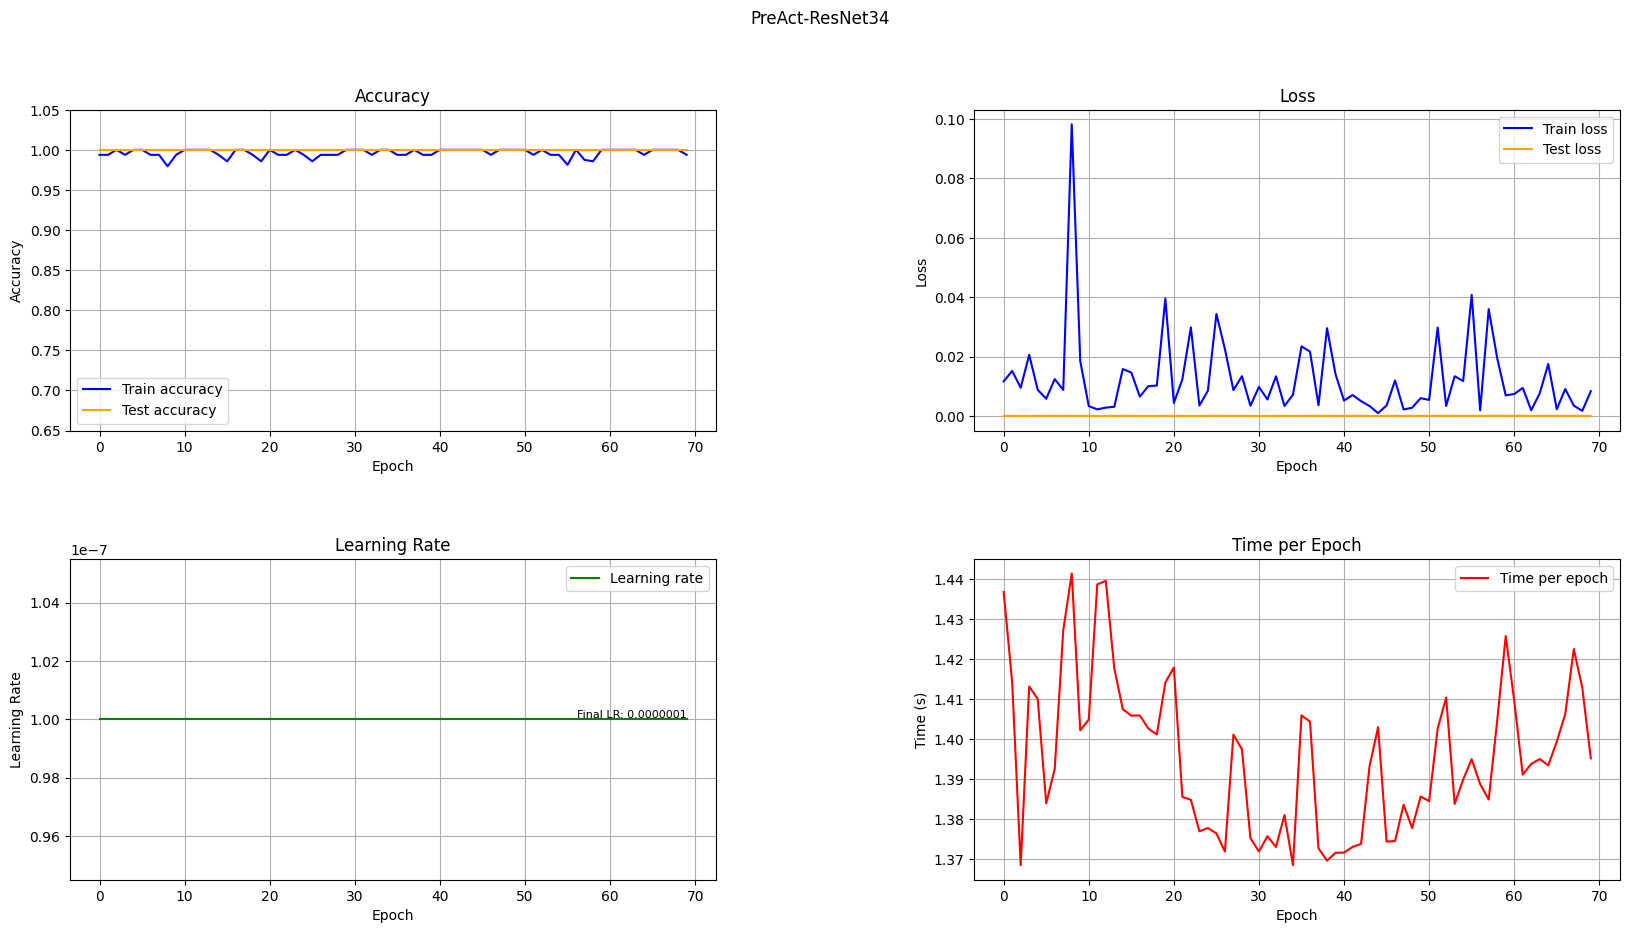

In [121]:
from src.utils import plot_graphs

plot_graphs(history, "PreAct-ResNet34")

In [122]:
# save model
from src.trainmodel import save_model
gdrive_path = '/content/drive/MyDrive/Colab Notebooks/sur/checkpoints/'

model_preact_resnet34.load_state_dict(best_model_w)
save_model(model_preact_resnet34, optimizer_sgd, cfg.EPOCHS, gdrive_path+f"img_model-PreAct-ResNet34-{best_epoch}e", history)